In [1]:
from kinisi.diffusion_analyzer import DiffusionAnalyzer 
from pymatgen.io.vasp import Xdatcar
import scipp as sc

In [2]:
xd = Xdatcar('./example_XDATCAR.gz')

In [3]:
time_step = 2.0 * sc.Unit('fs')
step_skip = 50 * sc.Unit('dimensionless')

In [4]:
p = DiffusionAnalyzer.from_Xdatcar(xd.structures, {'specie': 'Li', 'time_step': time_step, 'step_skip': step_skip, 'dimension': 'xy'})

Reading Trajectory: 100%|██████████| 140/140 [00:00<00:00, 9091.65it/s]


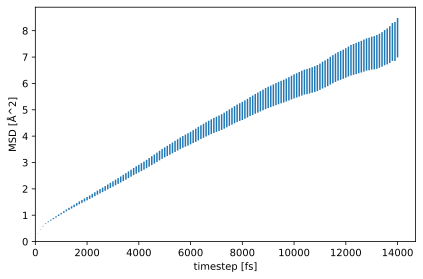

In [5]:
f = p.msd.plot(marker='')
f.canvas.ylabel = 'MSD ' + f.canvas.ylabel
f.canvas.xmin = 0
f.canvas.ymin = 0
f

In [6]:
p.msd.unit

Å^2

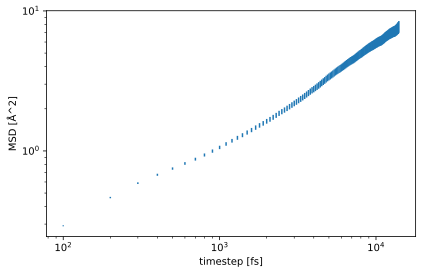

In [7]:
f = p.msd.plot(marker='', norm='log', scale={'timestep': 'log'})
f.canvas.ylabel = 'MSD ' + f.canvas.ylabel
f

In [8]:
p.msd.coords['n_samples']

<scipp.Variable> (timestep: 140)    float64  [dimensionless]  [26880, 13440, ..., 193.381, 192]

In [9]:
start_of_diffusion = 3000 * sc.Unit('fs')
p.diffusion(start_of_diffusion)

Likelihood Sampling: 100%|██████████| 1500/1500 [00:02<00:00, 559.15it/s]


In [10]:
p.diff.D

<scipp.Variable> (samples: 3200)    float64         [cm^2/s]  [1.44365e-05, 1.05004e-05, ..., 1.13639e-05, 1.14977e-05]

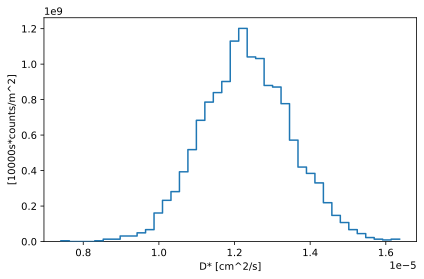

In [11]:
f = sc.counts_to_density(p.diff.D.hist(samples=40), dim='samples').plot()
f.canvas.xlabel = f'D* [{p.diff.D.unit}]'
f.canvas.ymin = 0
f

In [12]:
import numpy as np

In [13]:
distributions = p.diff.gradient.values * p.msd.coords['timestep'].values[:, np.newaxis] + p.diff.intercept.values

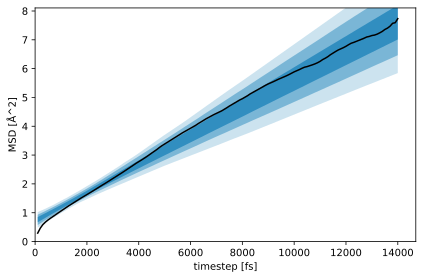

In [14]:
credible_intervals = [[16, 84], [2.5, 97.5], [0.15, 99.85]]
alpha = [0.6, 0.4, 0.2]

f = p.msd.plot(marker='', ls='-', errorbars=False, color='k')
for i, ci in enumerate(credible_intervals):     
    f.ax.fill_between(p.msd.coords['timestep'].values,
                      *np.percentile(distributions, ci, axis=1),
                      alpha=alpha[i],
                      color='#0173B2',
                      lw=0)
f.canvas.ylabel = 'MSD ' + f.canvas.ylabel
f.canvas.xmin = 0
f.canvas.ymin = 0
f